In [ ]:
!pip install stim~=1.14
!pip install numpy~=1.0  # 1.0 instead of 2.0 for pymatching compatibility later
!pip install scipy

In [126]:
%load_ext autoreload
%autoreload 2

import stim
import numpy as np
# import matplotlib.pyplot as plt
from stim_utils import *
from stim_simulation_utils import *
print(stim.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.14.0


In [127]:
import importlib.util
import sys


def reload_file(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    your_file = importlib.util.module_from_spec(spec)
    sys.modules[name] = your_file
    spec.loader.exec_module(your_file)


reload_file("stim_simulation_utils", "stim_simulation_utils.py")
reload_file("stim_utils", "stim_utils.py")


In [140]:
#Code stabilizer definitions:
# X-type stabilizers
x_stabilizers = [
    [0, 1, 2, 3, 4, 5, 6, 7],
    [4, 5, 6, 7, 8, 9, 10, 11],
    [8, 9, 10, 11, 12, 13, 14, 15],
    [0, 1, 4, 5, 8, 9, 12, 13],
    [1, 2, 5, 6, 9, 10, 13, 14],
]

# Z-type stabilizers
z_stabilizers = [
    [0, 1, 2, 3, 4, 5, 6, 7],
    [4, 5, 6, 7, 8, 9, 10, 11],
    [8, 9, 10, 11, 12, 13, 14, 15],
    [0, 1, 4, 5, 8, 9, 12, 13],
    [1, 2, 5, 6, 9, 10, 13, 14],
]


# general circuit helper functions:
def append_stabilizer(circuit, pauli_type, targets):
    """Append a multi-qubit Pauli product measurement to the circuit."""
    pauli_targets = []
    for t in targets:
        if pauli_type == 'X':
            pauli_targets.append(stim.target_x(t))
        elif pauli_type == 'Z':
            pauli_targets.append(stim.target_z(t))
        # Add a combiner for each qubit except the last one
        pauli_targets.append(stim.target_combiner())

    # Remove the last combiner (no combiner after the final target)
    pauli_targets.pop()

    # Append the MPP operation with the constructed targets
    circuit.append("MPP", pauli_targets)
    circuit.append("TICK")


def append_detector(circuit, index1, index2):
    """Append a DETECTOR instruction with two recorded targets."""
    circuit.append("DETECTOR", [
        stim.target_rec(index1),
        stim.target_rec(index2)
    ])


#Tesseract code circuit creation functions:

## Trying to create circuit from tableau based on stabilizer generators
# In order to encode some codeword in the codespace, I've used this reference:
# https://quantumcomputing.stackexchange.com/questions/32437/a-simple-way-of-encoding-qubit-in-stabilizer-codes-with-stim
def init_circuit():
    circuit = stim.Circuit()
    # Adding qubit coordinates metadata
    for qubit in range(16):
        x = qubit % 4
        y = qubit // 4
        circuit.append_operation("QUBIT_COORDS", [qubit], [x, y])
    print("Initialization complete.")
    return circuit


def encode(circuit):
    # Encoding step: Measuring X and Z stabilizers:

    # Append X-type stabilizers
    for targets in x_stabilizers:
        append_stabilizer(circuit, 'X', targets)

    # Append Z-type stabilizers
    for targets in z_stabilizers:
        append_stabilizer(circuit, 'Z', targets)

    print("Encoding complete.")


def channel(circuit, error_rate, noisy_qubits=list(range(16))):
    # Noise channel: Adding X errors with probability 0 (for testing, can be adjusted)
    circuit.append("TICK")
    circuit.append("DEPOLARIZE1", noisy_qubits, error_rate)  # 10% error probability for demonstration
    circuit.append("TICK")
    print("Noise channel applied.")


def error_correction(circuit):
    # Error correction: Measuring the stabilizers again

    # Append X-type stabilizers
    for targets in x_stabilizers:
        append_stabilizer(circuit, 'X', targets)

    # Append Z-type stabilizers
    for targets in z_stabilizers:
        append_stabilizer(circuit, 'Z', targets)

    # Adding detectors for error syndrome extraction
    # Append DETECTOR instructions to matching measurements
    for i in range(10):
        append_detector(circuit, index1=-(10 - i), index2=-(20 - i))

    # Logical observables and corresponding observable indices
    logical_observables = [
        (['Z', [0, 4, 8, 12]], 0),
        (['Z', [0, 1, 2, 3]], 1),
        (['Z', [0, 1, 4, 5]], 2),
        (['Z', [5, 6, 9, 10]], 3),
        (['Z', [4, 5, 8, 9]], 4),
        (['Z', [1, 2, 5, 6]], 5),
    ]

    # Append logical observables
    for (pauli_type, targets), observable_index in logical_observables:
        # Append the stabilizer measurement
        append_stabilizer(circuit, pauli_type, targets)

        # Inline the OBSERVABLE_INCLUDE operation
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], observable_index)

    print("Error correction complete.")


## Creating 1 circuit:

In [141]:
# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Apply noise channel
channel(circuit, 0.5, [0])

# Perform error correction
error_correction(circuit)

# Print the final circuit for verification
print(circuit)

Initialization complete.
Encoding complete.
Noise channel applied.
Error correction complete.
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(0, 1) 4
QUBIT_COORDS(1, 1) 5
QUBIT_COORDS(2, 1) 6
QUBIT_COORDS(3, 1) 7
QUBIT_COORDS(0, 2) 8
QUBIT_COORDS(1, 2) 9
QUBIT_COORDS(2, 2) 10
QUBIT_COORDS(3, 2) 11
QUBIT_COORDS(0, 3) 12
QUBIT_COORDS(1, 3) 13
QUBIT_COORDS(2, 3) 14
QUBIT_COORDS(3, 3) 15
MPP X0*X1*X2*X3*X4*X5*X6*X7
TICK
MPP X4*X5*X6*X7*X8*X9*X10*X11
TICK
MPP X8*X9*X10*X11*X12*X13*X14*X15
TICK
MPP X0*X1*X4*X5*X8*X9*X12*X13
TICK
MPP X1*X2*X5*X6*X9*X10*X13*X14
TICK
MPP Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7
TICK
MPP Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11
TICK
MPP Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15
TICK
MPP Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13
TICK
MPP Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14
TICK
TICK
DEPOLARIZE1(0.5) 0
TICK
MPP X0*X1*X2*X3*X4*X5*X6*X7
TICK
MPP X4*X5*X6*X7*X8*X9*X10*X11
TICK
MPP X8*X9*X10*X11*X12*X13*X14*X15
TICK
MPP X0*X1*X4*X5*X8*X9*X12*X13
TICK
MPP X1*X2*X5*X6*X9*X10*X13*X14
TICK
M

## plot multiple runs with different error rates

Initialization complete.
Encoding complete.
Running simulation for error rate: 0.00
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.01
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.03
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.04
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.06
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.07
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.09
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.10
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.12
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.14
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.15
Noise channel ap

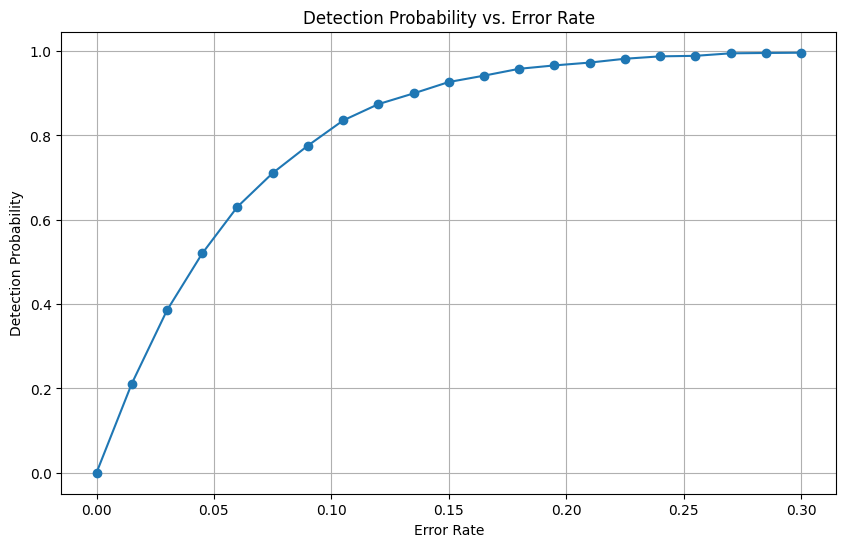

In [142]:
# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Define a range of error rates to test
error_rates = np.linspace(0, 0.3, 21)  # From 0 to 0.2 in steps of 0.01
detection_probabilities = []

# Run the simulation for each error rate
for error_rate in error_rates:
    print(f"Running simulation for error rate: {error_rate:.2f}")
    detection_probability = run_simulation(circuit.copy(), channel, error_correction, error_rate)
    detection_probabilities.append(detection_probability)

# Plot the results
plot_detection_probability(error_rates, detection_probabilities)

## Plot multiple runs with different error rates - fidelity
(probably not correct, was done with help of GPT)

Initialization complete.
Encoding complete.
Calculating fidelity for error rate: 0.00
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.01
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.02
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.03
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.04
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.05
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.06
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.07
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.08
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.09
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate:

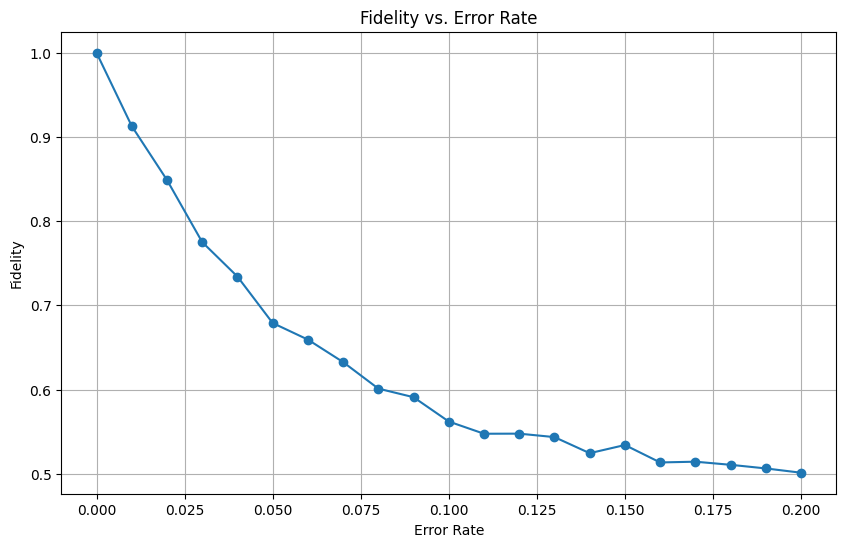

In [143]:
# Initialize the circuit
circuit = init_circuit()
encode(circuit)

# Define a range of error rates to test
error_rates = np.linspace(0, 0.2, 21)
fidelities = []

# Run fidelity calculations for each error rate
for error_rate in error_rates:
    print(f"Calculating fidelity for error rate: {error_rate:.2f}")
    fidelity = calculate_fidelity(circuit.copy(), channel, error_correction, error_rate)
    fidelities.append(fidelity)

# Plot the fidelity results
plot_fidelity(error_rates, fidelities)

In [144]:
circuit.to_crumble_url()

'https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(0,1)4;Q(1,1)5;Q(2,1)6;Q(3,1)7;Q(0,2)8;Q(1,2)9;Q(2,2)10;Q(3,2)11;Q(0,3)12;Q(1,3)13;Q(2,3)14;Q(3,3)15;MPP_X0*X1*X2*X3*X4*X5*X6*X7;TICK;MPP_X4*X5*X6*X7*X8*X9*X10*X11;TICK;MPP_X8*X9*X10*X11*X12*X13*X14*X15;TICK;MPP_X0*X1*X4*X5*X8*X9*X12*X13;TICK;MPP_X1*X2*X5*X6*X9*X10*X13*X14;TICK;MPP_Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7;TICK;MPP_Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11;TICK;MPP_Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15;TICK;MPP_Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13;TICK;MPP_Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14;TICK'

In [145]:
sampler = circuit.compile_sampler()
sampler.sample(shots=10)

array([[False,  True,  True, False, False, False, False, False, False,
        False],
       [ True, False, False, False,  True, False, False, False, False,
        False],
       [False, False,  True,  True,  True, False, False, False, False,
        False],
       [ True, False, False,  True, False, False, False, False, False,
        False],
       [False,  True, False,  True, False, False, False, False, False,
        False],
       [ True, False, False,  True,  True, False, False, False, False,
        False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False],
       [False,  True, False, False, False, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False],
       [False,  True, False,  True,  True, False, False, False, False,
        False]])

In [146]:
sampler = circuit.compile_detector_sampler()
sampler.sample(shots=5)

array([], shape=(5, 0), dtype=bool)

## Error correction with pymatching
Attempt at actually doing the error correction using pymatching
currently not working

In [150]:
# Creating another circuit (Can delete this - duplicate. this is just for easier work)
# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Apply noise channel
# channel(circuit, 0.05)
channel(circuit, 0.5, [0,1,2])

# Perform error correction
error_correction(circuit)

# Print the final circuit for verification
print(circuit)

dem = circuit.detector_error_model(decompose_errors=True)
print("******************************")
print("Noise model:")
print(repr(dem))

Initialization complete.
Encoding complete.
Noise channel applied.
Error correction complete.
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(0, 1) 4
QUBIT_COORDS(1, 1) 5
QUBIT_COORDS(2, 1) 6
QUBIT_COORDS(3, 1) 7
QUBIT_COORDS(0, 2) 8
QUBIT_COORDS(1, 2) 9
QUBIT_COORDS(2, 2) 10
QUBIT_COORDS(3, 2) 11
QUBIT_COORDS(0, 3) 12
QUBIT_COORDS(1, 3) 13
QUBIT_COORDS(2, 3) 14
QUBIT_COORDS(3, 3) 15
MPP X0*X1*X2*X3*X4*X5*X6*X7
TICK
MPP X4*X5*X6*X7*X8*X9*X10*X11
TICK
MPP X8*X9*X10*X11*X12*X13*X14*X15
TICK
MPP X0*X1*X4*X5*X8*X9*X12*X13
TICK
MPP X1*X2*X5*X6*X9*X10*X13*X14
TICK
MPP Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7
TICK
MPP Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11
TICK
MPP Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15
TICK
MPP Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13
TICK
MPP Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14
TICK
TICK
DEPOLARIZE1(0.5) 0 1 2
TICK
MPP X0*X1*X2*X3*X4*X5*X6*X7
TICK
MPP X4*X5*X6*X7*X8*X9*X10*X11
TICK
MPP X8*X9*X10*X11*X12*X13*X14*X15
TICK
MPP X0*X1*X4*X5*X8*X9*X12*X13
TICK
MPP X1*X2*X5*X6*X9*X10*X13*X14
TI

In [151]:
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 0 wrong predictions (logical errors) out of 100000 shots


In [137]:
circuit.diagram("timeline-text")

/-----------------------------\                                                                                                                                                                                                                                                                                                    /------------------------------------------------------------------------------------------------------------------------\ /-------------------------------------------\ /-------------------------------------------\                                /-------------------------------------------\ /-------------------------------------------\
 q0: -QUBIT_COORDS(0,0)-MPP[X]:rec[0]-----------------------------MPP[X]:rec[3]---------------MPP[Z]:rec[5]-----------------------------MPP[Z]:rec[8]-----------------Z_ERROR(0.5)-MPP[X]:rec[10]-------------------------------MPP[X]:rec[13]----------------MPP[Z]:rec[15]-------------------------------MPP[Z]:rec[18]----------------DETECTOR:D0=rec[10]*rec[0]-DETECTOR:D3=rec[13]*rec[3]-DETECTOR:D5=rec[15]*rec[5]-DETECTOR:D8=rec[18]*rec[8]-MPP[Z]:rec[20]-OBSERVABLE_INCLUDE:L0*=rec[20]-MPP[Z]:rec[21]-OBSERVABLE_INCLUDE:L1*=rec[21]-MPP[Z]:rec[22]-OBSERVABLE_INCLUDE:L2*=rec[22]----------------------------------------------------------------------------------------------------------------------------
                        |                                         |                           |                                         |                                          |                                            |                             |                                            |                                                                                                                                         |                                             |                                             |
 q1: -QUBIT_COORDS(1,0)-MPP[X]:rec[0]-----------------------------MPP[X]:rec[3]-MPP[X]:rec[4]-MPP[Z]:rec[5]-----------------------------MPP[Z]:rec[8]-MPP[Z]:rec[9]---Z_ERROR(0.5)-MPP[X]:rec[10]-------------------------------MPP[X]:rec[13]-MPP[X]:rec[14]-MPP[Z]:rec[15]-------------------------------MPP[Z]:rec[18]-MPP[Z]:rec[19]----------------------------DETECTOR:D4=rec[14]*rec[4]----------------------------DETECTOR:D9=rec[19]*rec[9]-|---------------------------------------------MPP[Z]:rec[21]--------------------------------MPP[Z]:rec[22]-------------------------------------------------------------------------------------------------------------MPP[Z]:rec[25]-OBSERVABLE_INCLUDE:L5*=rec[25]-
                        |                                         |             |             |                                         |             |                            |                                            |              |              |                                            |              |                                                                                                                          |                                             |                                             |                                                                                                                          |
 q2: -QUBIT_COORDS(2,0)-MPP[X]:rec[0]-----------------------------|-------------MPP[X]:rec[4]-MPP[Z]:rec[5]-----------------------------|-------------MPP[Z]:rec[9]---Z_ERROR(0.5)-MPP[X]:rec[10]-------------------------------|--------------MPP[X]:rec[14]-MPP[Z]:rec[15]-------------------------------|--------------MPP[Z]:rec[19]-------------------------------------------------------------------------------------------------------------|---------------------------------------------MPP[Z]:rec[21]--------------------------------|--------------------------------------------------------------------------------------------------------------------------MPP[Z]:rec[25]--------------------------------
                        |                                

In [108]:
circuit.to_crumble_url()

'https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(0,1)4;Q(1,1)5;Q(2,1)6;Q(3,1)7;Q(0,2)8;Q(1,2)9;Q(2,2)10;Q(3,2)11;Q(0,3)12;Q(1,3)13;Q(2,3)14;Q(3,3)15;MPP_X0*X1*X2*X3*X4*X5*X6*X7;TICK;MPP_X4*X5*X6*X7*X8*X9*X10*X11;TICK;MPP_X8*X9*X10*X11*X12*X13*X14*X15;TICK;MPP_X0*X1*X4*X5*X8*X9*X12*X13;TICK;MPP_X1*X2*X5*X6*X9*X10*X13*X14;TICK;MPP_Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7;TICK;MPP_Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11;TICK;MPP_Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15;TICK;MPP_Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13;TICK;MPP_Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14;TICK;TICK;X_ERROR(0.5)0;TICK;MPP_X0*X1*X2*X3*X4*X5*X6*X7;TICK;MPP_X4*X5*X6*X7*X8*X9*X10*X11;TICK;MPP_X8*X9*X10*X11*X12*X13*X14*X15;TICK;MPP_X0*X1*X4*X5*X8*X9*X12*X13;TICK;MPP_X1*X2*X5*X6*X9*X10*X13*X14;TICK;MPP_Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7;TICK;MPP_Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11;TICK;MPP_Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15;TICK;MPP_Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13;TICK;MPP_Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14;TICK;DT_rec[-10]_rec[-20];DT_rec[-9]_rec[-19];DT_rec[-8]_rec[-18];DT_rec[-7]_rec[-17];DT_rec[-6]